## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [90]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(reviews.isnull().sum())
print(labels.isnull().sum())
print(Y.value_counts())
display(reviews.head())
display(labels.head())
display(Y.head())

0    0
dtype: int64
0    0
dtype: int64
0
0    12500
1    12500
Name: count, dtype: int64


,0
0,bromwell high is a cartoon comedy . it ran at ...
1,story of a man who has unnatural feelings for ...
2,homelessness or houselessness as george carli...
3,airport starts as a brand new luxury pla...
4,brilliant over acting by lesley ann warren . ...


,0
0,positive
1,negative
2,positive
3,negative
4,positive


,0
0,1
1,0
2,1
3,0
4,1


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_temp, X_test, y_temp, y_test = train_test_split(
    reviews, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


vectorizer = CountVectorizer(binary=True, max_features=10_000)  # binary=True: only 0/1 if word appears

X_train_vec = vectorizer.fit_transform(X_train[0])
X_val_vec = vectorizer.transform(X_val[0])
X_test_vec = vectorizer.transform(X_test[0])

Train size: 15000
Validation size: 5000
Test size: 5000


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [92]:
print("Vocabulary:", vectorizer.vocabulary_)
print("Index of word 'good':", vectorizer.vocabulary_.get('good'))

Vocabulary: {'did': 2459, 'not': 6057, 'expect': 3146, 'lot': 5304, 'from': 3634, 'this': 9002, 'movie': 5829, 'after': 169, 'the': 8956, 'terrible': 8926, 'life': 5165, 'is': 4732, 'miracle': 5685, 'it': 4745, 'turns': 9288, 'out': 6258, 'that': 8954, 'ten': 8907, 'times': 9068, 'worse': 9916, 'than': 8948, 'have': 4098, 'impression': 4466, 'director': 2501, 'writer': 9941, 'just': 4885, 'joking': 4836, 'with': 9860, 'audience': 588, 'let': 5143, 'me': 5539, 'see': 7791, 'how': 4322, 'much': 5839, 'can': 1238, 'you': 9975, 'sustain': 8766, 'dialogues': 2450, 'are': 452, 'empty': 2925, 'scenario': 7699, 'in': 4477, 'few': 3366, 'moments': 5753, 'photography': 6529, 'really': 7128, 'nice': 5995, 'sarcastic': 7659, 'lines': 5206, 'semi': 7820, 'funny': 3665, 'but': 1186, 'hard': 4062, 'to': 9084, 'genuinely': 3755, 'laugh': 5057, 'during': 2762, 'comedy': 1702, 've': 9516, 'laughed': 5060, 'myself': 5884, 'for': 3535, 'being': 794, 'able': 5, 'watch': 9698, 'until': 9440, 'end': 2936, 'i

In [93]:
sample_text = X_train.iloc[0, 0]
print("Original text:\n", sample_text)

vectorized = vectorizer.transform([sample_text])
print("Vector shape:", vectorized.shape)
print("Non-zero entries (word positions that appear):", vectorized.nonzero()[1])

Original text:
 i did not expect a lot from this movie  after the terrible  life is a miracle  . it turns out that this movie is ten times worse than  life . . .  . i have impression that director  writer is just joking with the audience  let me see how much emptiness can you  audience  sustain  . dialogues are empty  . . . scenario is minimalistic . in few moments  photography is really nice . few sarcastic lines are semi  funny  but it is hard to genuinely laugh during this  comedy  . i  ve laughed to myself for being able to watch the movie until the end . if you can lift yourself above this director  s fiasco  . . . you will find good acting of few legends  miki manojlovic  aleksandar bercek   and very good performance of emir  s son stribor kusturica .  br    br   in short too bad for such a great director  emir kusturica is still young and should be making top  rated movies . instead  he chooses to do this low  budget just  for  my  private theater movie  with arrogant attitude t

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    layers.Input(shape=(X_train_vec.shape[1],)),  
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid')  
])

early_stopping = EarlyStopping(
    monitor='val_loss',         
    patience=3,                 
    restore_best_weights=True   
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',         
    metrics=['accuracy']
)

history = model.fit(
    X_train_vec.toarray(), y_train.values,   
    validation_data=(X_val_vec.toarray(), y_val.values),  
    epochs=25,                                 
    callbacks= [early_stopping],
    batch_size=16
)



Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7890 - loss: 0.8558 - val_accuracy: 0.8520 - val_loss: 0.7273
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8521 - loss: 0.7272 - val_accuracy: 0.8344 - val_loss: 0.7502
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8459 - loss: 0.7409 - val_accuracy: 0.8502 - val_loss: 0.7261
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8544 - loss: 0.7375 - val_accuracy: 0.8604 - val_loss: 0.7121
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8462 - loss: 0.7236 - val_accuracy: 0.8574 - val_loss: 0.7087
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8569 - loss: 0.7147 - val_accuracy: 0.8594 - val_loss: 0.7270
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8584 - loss: 0.7079 - val_accuracy: 0.8558 - val_loss: 0.7162
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8576 - loss: 0.7073 - val_accuracy: 0.

In [95]:
train_loss, train_acc = model.evaluate(X_train_vec.toarray(), y_train.values)
val_loss, val_acc = model.evaluate(X_val_vec.toarray(), y_val.values)
print("Train Accuracy:", train_acc)
print("Model Loss on Train set: ", train_loss)

print("Validation Accuracy:", val_acc)
print("Model Loss on validation set: ", val_loss)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9045 - loss: 0.5927
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.6644
Train Accuracy: 0.9055333137512207
Model Loss on Train set:  0.5932163000106812
Validation Accuracy: 0.8704000115394592
Model Loss on validation set:  0.6543812155723572


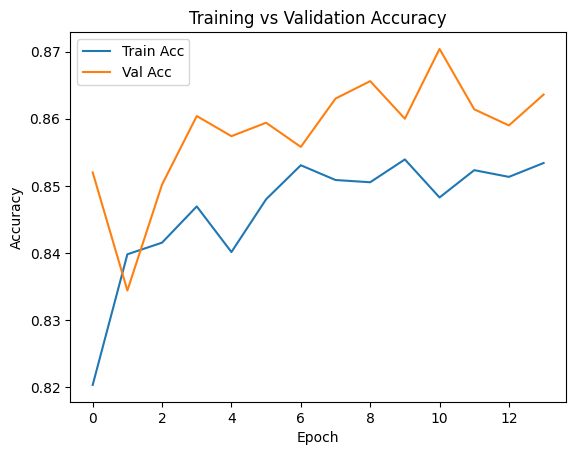

In [96]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

**(d)** Test your sentiment-classifier on the test set.

In [97]:
test_loss, test_acc = model.evaluate(X_test_vec.toarray(), y_test.values)
print("Test Accuracy:", test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.6684
Test Accuracy: 0.850600004196167


In [98]:
from sklearn.metrics import classification_report

y_test_pred_probs = model.predict(X_test_vec.toarray())
y_test_pred = (y_test_pred_probs > 0.5).astype(int)  

print(classification_report(y_test, y_test_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2500
           1       0.83      0.87      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


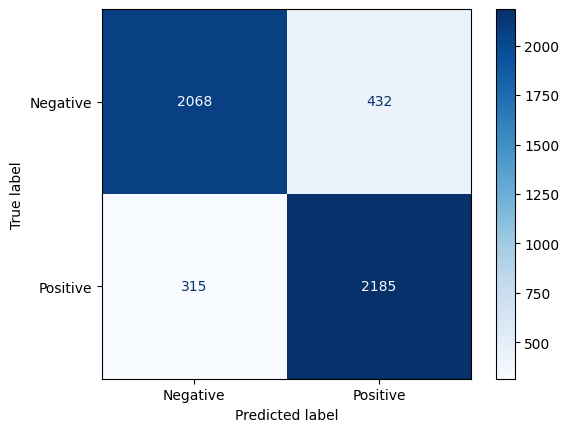

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred_probs = model.predict(X_test_vec.toarray())
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [100]:
my_reviews = [
    "This movie was absolutely amazing! I loved every second of it.",
    "The plot was boring and the acting was terrible.",
    "The best class, Richard is the G.O.A.T.",
    "It was okay, not great but not the worst either."
    "I hated the ending, but the cinematography was beautiful.",
    "This is the best film I’ve seen in years!"
]

my_reviews_vec = vectorizer.transform(my_reviews)
my_preds = model.predict(my_reviews_vec.toarray())

for review, prob in zip(my_reviews, my_preds):
    label = "Positive" if prob > 0.5 else "Negative"
    print(f"{label.upper()} ({prob[0]:.2f}): {review}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
POSITIVE (0.82): This movie was absolutely amazing! I loved every second of it.
NEGATIVE (0.10): The plot was boring and the acting was terrible.
POSITIVE (0.83): The best class, Richard is the G.O.A.T.
NEGATIVE (0.41): It was okay, not great but not the worst either.I hated the ending, but the cinematography was beautiful.
POSITIVE (0.90): This is the best film I’ve seen in years!
